In [1]:
import re
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics

In [2]:
def read_bw(f):
    lines = []
    for a in f:
        if a.startswith("Starting"):
            lines.append(a.rstrip())
        elif ("Mbits/sec" in a):
            lines.append(a.strip())
    data = []
    for i in range(0, len(lines), 2):
        numbers = re.findall(r'\d+', lines[i])
        if numbers:
            numbers.append(re.findall(r'\d+', lines[i+1])[0])
            data.append(numbers)
    return data

sev1 = read_bw(open("../generator/output_snp_1.log", "r").readlines())
sev2 = read_bw(open("../generator/output_snp_2.log", "r").readlines())
sev3 = read_bw(open("../generator/output_snp_3.log", "r").readlines())
sevr1 = read_bw(open("../generator/output_snp_rules_1.log", "r").readlines())
sevr2 = read_bw(open("../generator/output_snp_rules_2.log", "r").readlines())
sevr3 = read_bw(open("../generator/output_snp_rules_3.log", "r").readlines())
van1 = read_bw(open("../generator/output_vanilla_1.log", "r").readlines())
van2 = read_bw(open("../generator/output_vanilla_2.log", "r").readlines())
van3 = read_bw(open("../generator/output_vanilla_3.log", "r").readlines())
vanr1 = read_bw(open("../generator/output_vanilla_rules_1.log", "r").readlines())
vanr2 = read_bw(open("../generator/output_vanilla_rules_2.log", "r").readlines())
vanr3 = read_bw(open("../generator/output_vanilla_rules_3.log", "r").readlines())

In [3]:
def standard_deviation(numbers):
  mean = statistics.mean(numbers)
  variance = 0
  for number in numbers:
    squared_distance_from_mean = (number - mean)**2
    variance += squared_distance_from_mean
  standard_deviation = statistics.sqrt(variance / len(numbers))
  return standard_deviation

def avgdata_norules(i1, i2, i3):
    o = []
    for a in range (0,len(i1)):
        v1 = int(i1[a][3])
        v2 = int(i2[a][3])
        v3 = int(i3[a][3])
        sd = standard_deviation([v1,v2,v3])
        m = statistics.mean([v1,v2,v3])
        o.append([int(i1[a][0]),int(i1[a][1]),int(i1[a][2]),m,sd])
    return o

def avgdata_rules(i1, i2, i3):
    o = []
    for a in range (0,len(i1)):
        v1 = int(i1[a][4])
        v2 = int(i2[a][4])
        v3 = int(i3[a][4])
        sd = standard_deviation([v1,v2,v3])
        m = statistics.mean([v1,v2,v3])
        o.append([int(i1[a][0]),int(i1[a][1]),int(i1[a][2]),int(i1[a][3]),m,sd])
    return o

sev = avgdata_norules(sev1,sev2,sev3)
sevr = avgdata_rules(sevr1,sevr2,sevr3)
van = avgdata_norules(van1,van2,van3)
vanr = avgdata_rules(vanr1,vanr2,vanr3)

In [4]:
def filterdata(key, num, inp_data, key2=None, num2=None):
    if key2 is not None and num2 is not None:
        keys = ['cpusnort', 'psize', 'tcpflows', 'rules', 'tput', 'sdev']
    else:
        keys = ['cpusnort', 'psize', 'tcpflows', 'tput', 'sdev']

    dict_data = [dict(zip(keys, row)) for row in inp_data]
    df = pd.DataFrame(dict_data)
    df[keys] = df[keys].apply(pd.to_numeric)
    
    df_filtered_1 = df[df['cpusnort'] == 1]
    df_filtered_1 = df_filtered_1[df_filtered_1[key] == num]

    df_filtered_2 = df[df['cpusnort'] == 2]
    df_filtered_2 = df_filtered_2[df_filtered_2[key] == num]

    if key2 is not None and num2 is not None:    
        df_filtered_1 = df_filtered_1[df_filtered_1[key2] == num2]    
        df_filtered_2 = df_filtered_2[df_filtered_2[key2] == num2]

    if key == "tcpflows":
        if key2 == "psize":
            x = np.arange(len(df_filtered_1['rules']))
            x_point = df_filtered_1['rules']
        else:
            x = np.arange(len(df_filtered_1['psize']))
            x_point = df_filtered_1['psize']
    elif key == "psize":
        x = np.arange(len(df_filtered_1['tcpflows']))    
        x_point = df_filtered_1['tcpflows']
 
    return x, x_point, df_filtered_1['tput'], df_filtered_1['sdev'], df_filtered_2['tput'], df_filtered_2['sdev']

In [5]:
def gambar(xlabel, ylabel, k1, v1, k2=None, v2=None):
    if k2 is not None and v2 is not None:
        x, xp, y1, y1_sd, y2, y2_sd = filterdata(k1, v1, vanr, k2, v2)
        x, xp, y3, y3_sd, y4, y4_sd = filterdata(k1, v1, sevr, k2, v2)
    else:
        x, xp, y1, y1_sd, y2, y2_sd = filterdata(k1, v1, van)
        x, xp, y3, y3_sd, y4, y4_sd = filterdata(k1, v1, sev)
    width = 0.12 

    fig, ax = plt.subplots(figsize=(8, 6)) # Increase figure size
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Use a consistent color palette
    labels = ['Vanilla 1 thread', 'SEV-SNP 1 thread', 'Vanilla 2 threads', 'SEV-SNP 2 threads']

    for i, (y, sd) in enumerate([(y1, y1_sd), (y3, y3_sd), (y2, y2_sd), (y4, y4_sd)]):
        ax.bar(x + (i-1.5)*width, y, width, yerr=sd, color=colors[i], label=labels[i], capsize=5)

    if k2 is not None and v2 is not None:
        title = ylabel + " vs " + xlabel + " for " + k1 + "=" + str(v1) + "," + k2 + "=" + str(v2)
    else:
        title = ylabel + " vs " + xlabel + " for " + k1 + "=" + str(v1) + ",rules=0"
    
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel+"(Mbps)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(xp, fontsize=12)
    ax.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=12)
    ax.set_ylim([0, 1800])
    ax.grid(True, linestyle='--', alpha=0.6) # Add grid lines
    fig.tight_layout()
    plt.show()

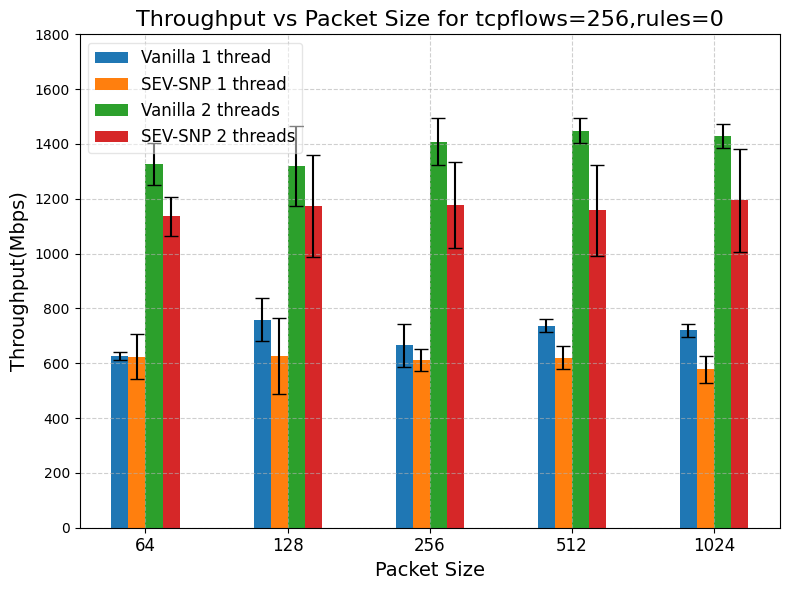

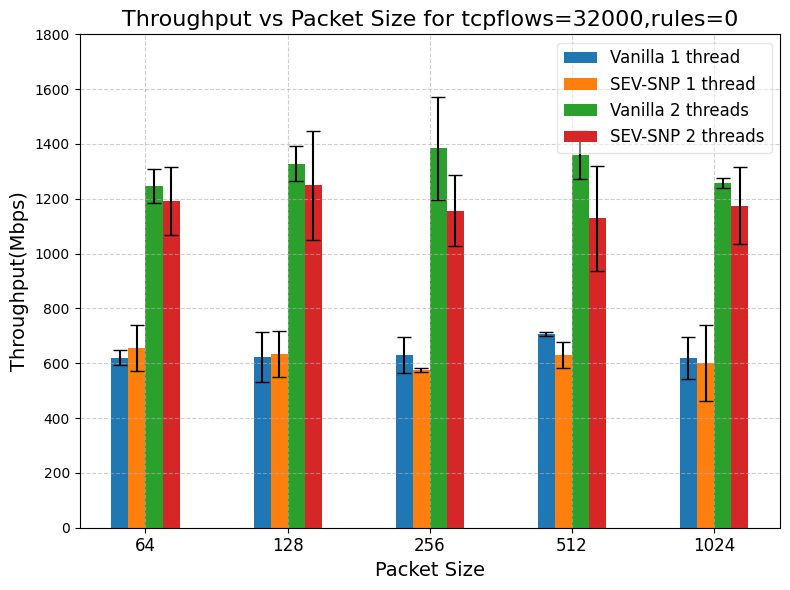

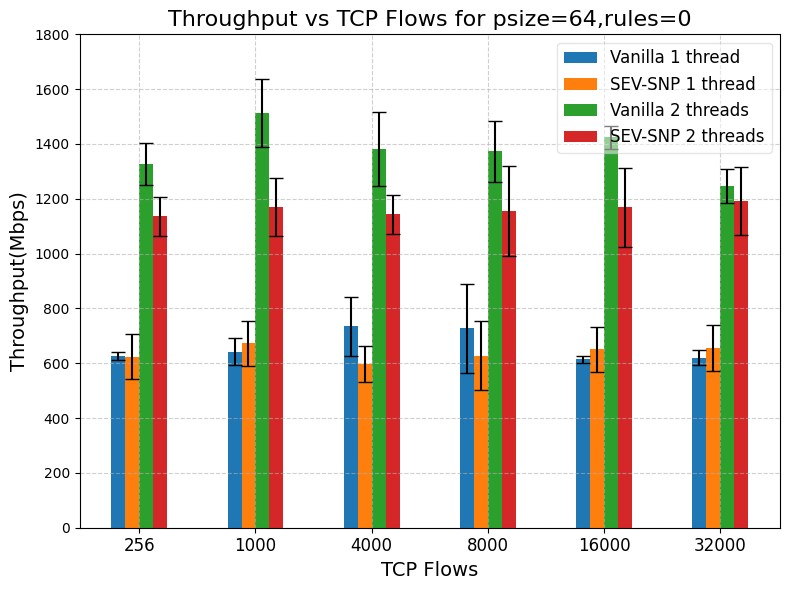

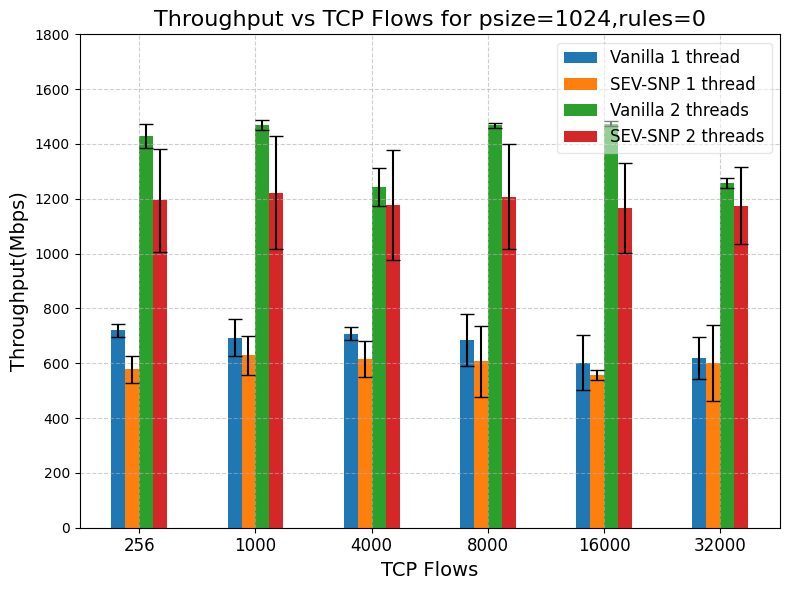

In [6]:
gambar("Packet Size", "Throughput", "tcpflows", 256)
gambar("Packet Size", "Throughput", "tcpflows", 32000)
gambar("TCP Flows", "Throughput", "psize", 64)
gambar("TCP Flows", "Throughput", "psize", 1024)

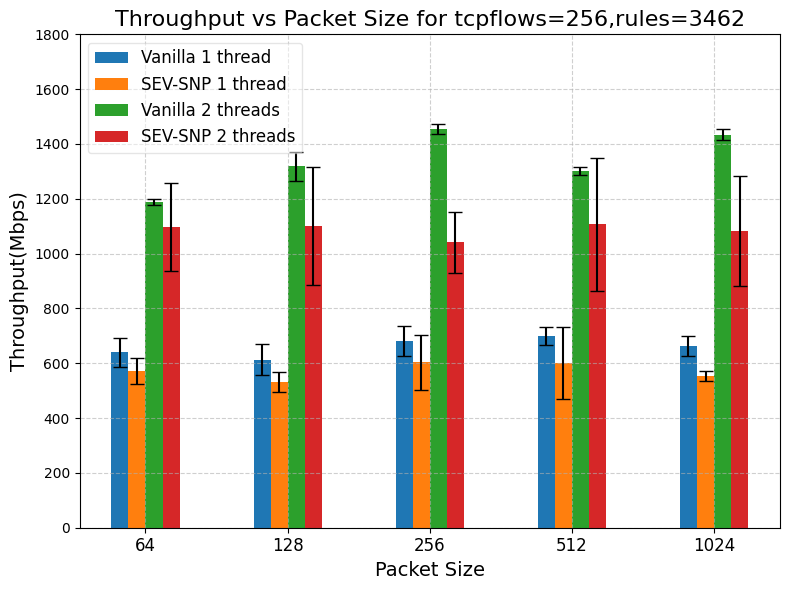

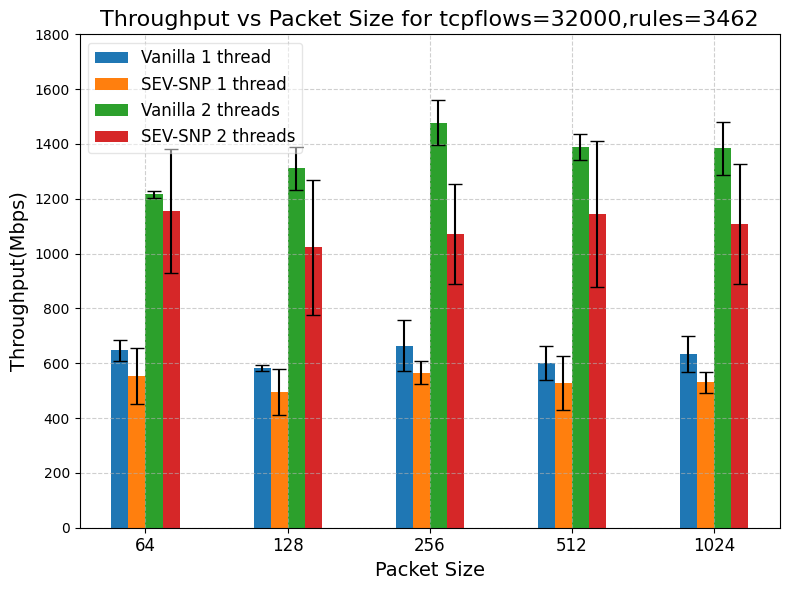

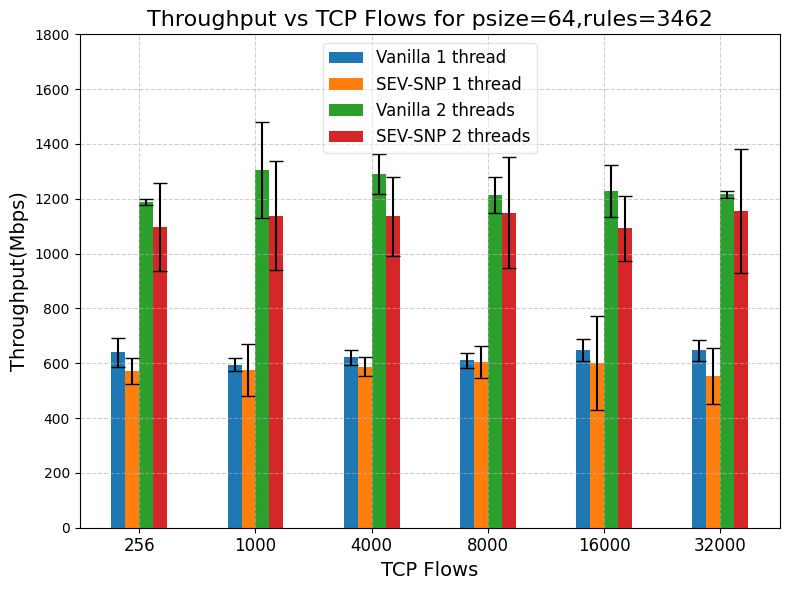

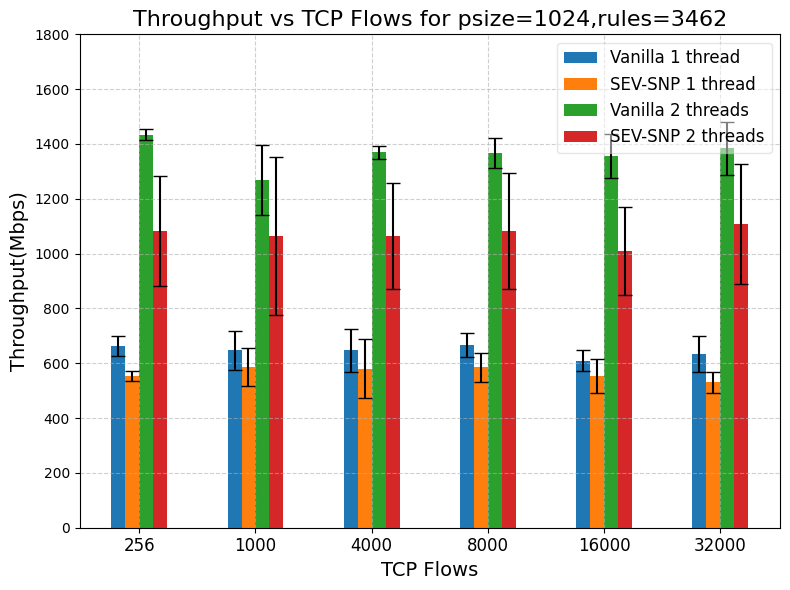

In [7]:
gambar("Packet Size", "Throughput", "tcpflows", 256, "rules", 3462)
gambar("Packet Size", "Throughput", "tcpflows", 32000, "rules", 3462)
gambar("TCP Flows", "Throughput", "psize", 64, "rules", 3462)
gambar("TCP Flows", "Throughput", "psize", 1024, "rules", 3462)

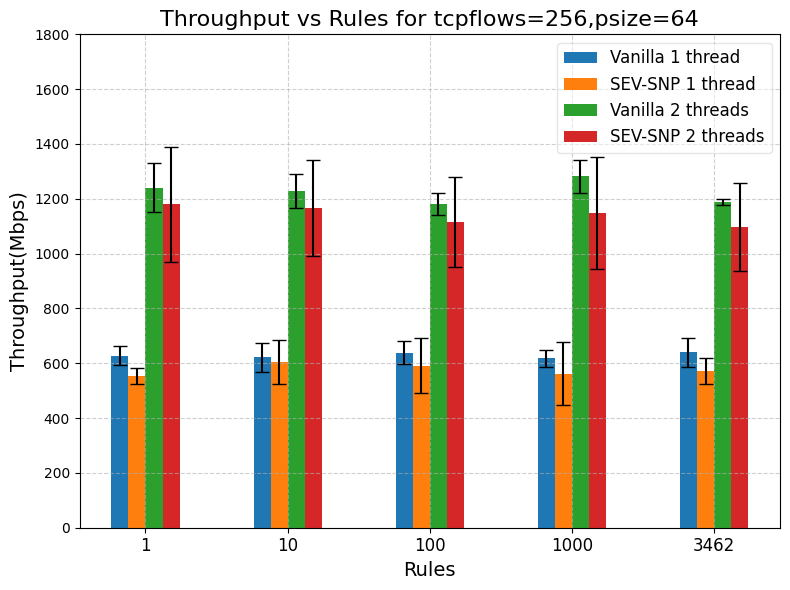

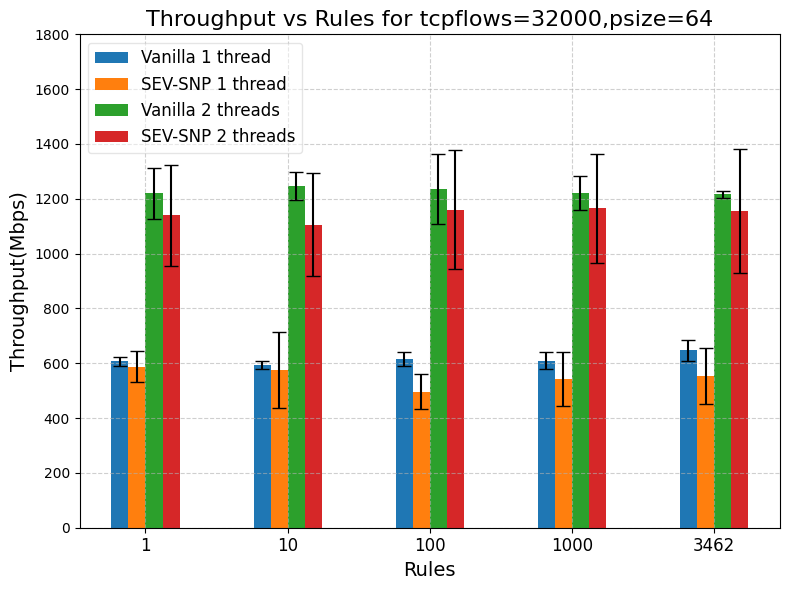

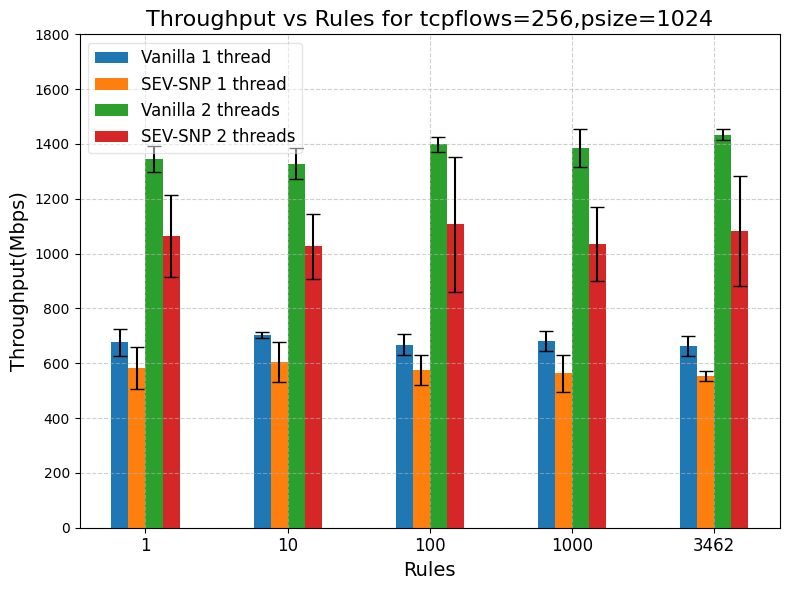

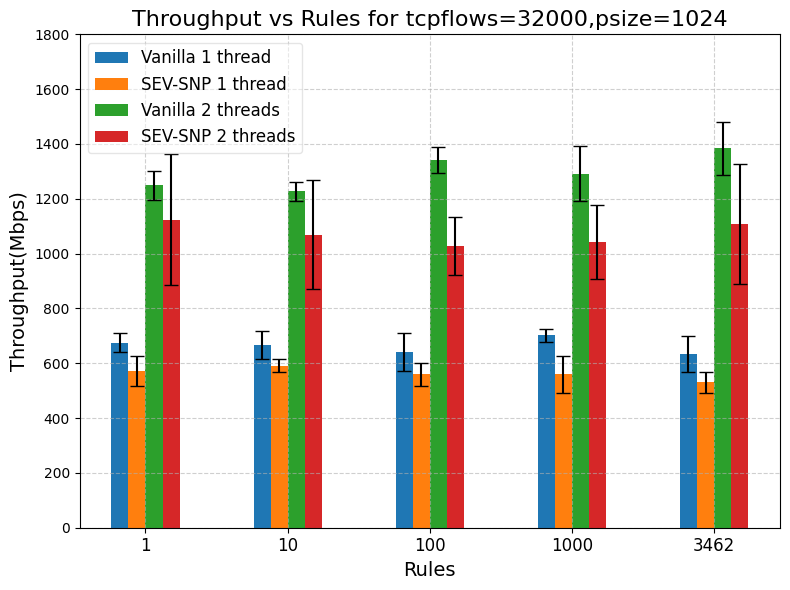

In [8]:
gambar("Rules", "Throughput", "tcpflows", 256, "psize", 64)
gambar("Rules", "Throughput", "tcpflows", 32000, "psize", 64)
gambar("Rules", "Throughput", "tcpflows", 256, "psize", 1024)
gambar("Rules", "Throughput", "tcpflows", 32000, "psize", 1024)